In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import seaborn as sns
import matplotlib as mpl
from scipy import stats
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Patch

# Table of contents <a name="contents"></a>
1. [Loading Data](#LoadingData)
2. [Clinical Data](#clinical)
3. [Cluster by Composition](#cluster1)
    1. [Cluster by scaled Composition](#clusterz)
    2. [HRStatus vs pcr](#HRstatus)
4. [Single Variable Associations](#singlevar)
5. [Cluster by Significant Variables](#cluster2)
6. [Misclassfied Samples](#misclass)
7. [Test Significance of Clusters](#clustersig)
8. [Correlation with HER2](#HER2)

##  <a name="example"></a>

# Loading Data <a name="LoadingData"></a>

### notes

Shayna used the RCB for pCR, based on Otto’s recommendation (see below), so it might be better to use that one to say consistent.

“Using the RCB definition might be better given its aligned with the study primary objectives and does provide us with information about pathology response in the breast and nodes.
RCB 0 stands for pCR; RCB-1 minimal residual disease. When performing the analyses we could also consider looking at RBC 0 and 1 combined given it’s a readout of excellent response to therapy.”

Difference from previous composition analysis: 

- Added PDPN to stromal cells

- Added Myeloid functional states

- Added GRNZB on CD4, CD8 and Myeloid (instead of just "Immune")

[contents](#contents)


In [39]:
#set location of files (download data and then specify location)
rootdir = r'/mnt/c/Users/engje/Documents/Data/2020/20200706_NP001-36'
# go to location of files
os.chdir(rootdir)
#os.listdir()

In [40]:
#load positive data
'''
s_pos_name = 'NP001-36_edge31'#'NP001-36_HER2B-TMAs'

s_date = '20201030'
#os.mkdir(s_date)
s_date_data = '20201023'
df_data = pd.read_csv(f'./{s_date_data}_{s_pos_name}_GatedPositiveCellNames.csv',index_col=0)

print(f'Loaded {s_date_data}_{s_pos_name}_GatedPositiveCellNames.csv')
df_data['Sample'] = [item.split('_')[0] for item in df_data.index]
df_data['countme'] = True
#df_data.dtypes
#set(df_data.slide)
#leave out TMAs
df_data = df_data[~df_data.Sample.isin(['HER2B-K169', 'HER2B-K172', 'HER2B-K174', 'Her2B-K153', 'Her2b-SD51','NP015'])] #,'NP015: high tissue loss in stroma; may need to analyze tissue loss in detail
'''

Loaded 20201023_NP001-36_edge31_GatedPositiveCellNames.csv


In [43]:
#df_data.to_csv(f'{s_date_data}_{s_pos_name}_GatedPositiveCellNames_smaller.csv')

In [47]:
#df_data.iloc[:500000].to_csv(f'{s_date_data}_{s_pos_name}_GatedPositiveCellNames_1.csv')
#df_data.iloc[500000:].to_csv(f'{s_date_data}_{s_pos_name}_GatedPositiveCellNames_2.csv')

In [52]:
#upload smaller files to github

In [41]:
os.chdir('HER2_heterogeneity_2021/cycIF')

In [53]:
s_pos_name = 'NP001-36_edge31'#'NP001-36_HER2B-TMAs'

s_date = '20201030'
#os.mkdir(s_date)
s_date_data = '20201023'
df_data = pd.read_csv(f'./{s_date_data}_{s_pos_name}_GatedPositiveCellNames_1.csv',index_col=0).append(pd.read_csv(f'./{s_date_data}_{s_pos_name}_GatedPositiveCellNames_2.csv',index_col=0))
print(f'Loaded {s_date_data}_{s_pos_name}_GatedPositiveCellNames.csv')
df_data['Sample'] = [item.split('_')[0] for item in df_data.index]
df_data['countme'] = True
print(len(df_data))

In [7]:
#load annotation
df_annot = pd.read_csv('./NP001-36.csv',index_col=0, dtype={'HMS':'str','Site_Core':'str','DF':'int'})
df_annot.index = [item.replace('_','-') for item in df_annot.index]

In [8]:
df_outcome = pd.read_csv('patients1_20.csv',index_col=0)
df_outcome.columns[df_outcome.columns.str.contains('pCR')]
#for s_index in df_outcome.index:
#    df_annot.loc[df_annot.DF==s_index,'pCR'] = int(df_outcome.loc[s_index,'pCR_breastANDaxilla'])
#df_annot = df_annot.astype({'pCR':'int'})
# add to dataframe
for s_sample in df_annot.index:
    df_data.loc[df_data.Sample==s_sample,'Patient'] = int(df_annot.loc[s_sample,'DF'])

In [9]:
#df_outcome.columns[df_outcome.columns.str.contains('pCR')]
#funny cases
#df_outcome.loc[df_outcome.loc[:,['pCR_breast', 'pCR_breast2', 'pCR_breastnoDCIS', 'pCR_axilla','pCR_breastANDaxilla']].sum(axis=1) == 0,'pCR_ba_noDCIS'] = int(0)
#df_outcome.loc[df_outcome.loc[:,['pCR_breast', 'pCR_breast2', 'pCR_breastnoDCIS', 'pCR_axilla','pCR_breastANDaxilla']].sum(axis=1) != 0,'pCR_ba_noDCIS'] = int(1)
#df_outcome = df_outcome.astype({'pCR_ba_noDCIS':'int'})

# use RCB
df_outcome.loc[df_outcome.loc[:,'RCB'] < 2,'pCR_RCB'] = int(0)
df_outcome.loc[df_outcome.loc[:,'RCB'] >=2,'pCR_RCB'] = int(1)
df_outcome = df_outcome.astype({'pCR_RCB':'int'})
#df_outcome.loc[:,['RCB','pCR_RCB']]

In [11]:
#check
df_outcome.loc[:,df_outcome.columns[df_outcome.columns.str.contains('pCR')]]
#9 non-responders
#df_outcome.pCR_breastANDaxilla.sum()
#13 non responders
#df_outcome.pCR_ba_noDCIS.sum()
#11 non responders
#df_outcome.pCR_breastnoDCIS.sum()
#7 non responders
df_outcome.pCR_RCB.sum()

7

In [12]:
# color of Pcr
#s_pcr = 'pCR_breastANDaxilla'
s_pcr = 'pCR_RCB'
lut_pcr = dict(zip([0,1],cm.tab10.colors))


# Look at clinical info <a name="clinical"></a>

Of the clinical info provided by Dana Farber, HER2_IHC_local and HER2_FISH_local are significantly associated with response to TDM-1. So are PathTstage, Path_histology, Tumor_location

Stage, grade, ER, PgR are not associated with response.

[contents](#contents)

In [13]:
df_outcome.columns

Index(['HER2_IHC_central', 'HER2_IHC_local', 'HER2_FISH_central',
       'HER2_FISH_local', 'RCB', 'pCR_RCB'],
      dtype='object')

In [14]:
#variables checked
#s_var = 'Heterogeneity'#'Surgery'#'ContrBreast'#'Tumor_location'#'HR_local '#'PgR_local'#'Clin_N_stage'#'Number of Treatment Cycles Started ~ xx'#'LVI'#'HG'#'Path_histology'
#'HR_Local10'#'PathTstage'#'Clin_T_stage'#'HER2_IHC_local'#'HER2_IHC_central'#'HER2_IHC_local'#'ER_local'#'HER2_IHC_central'#'Clin_stage'#
#df_outcome.loc[:,s_var]

0.0035272757074603974


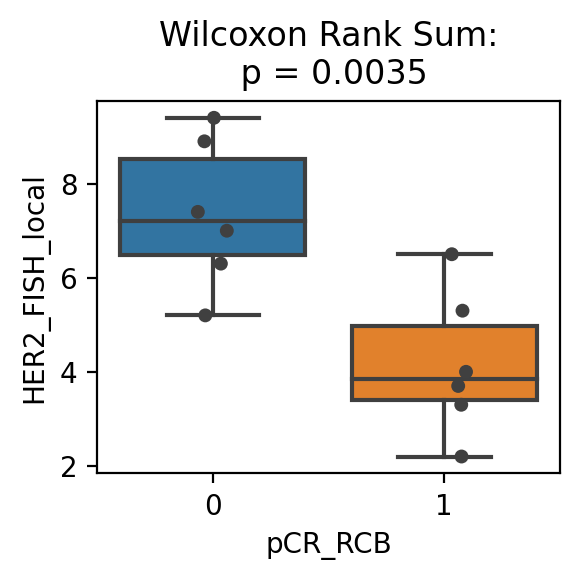

In [15]:
#categorical 'HER2_FISH_central' 'HER2_FISH_local'
s_var = 'HER2_FISH_local'
#normal?
#df_outcome.loc[:,s_var].plot(kind='hist')
fig,ax = plt.subplots(dpi=200,figsize=(3,3))
sns.boxplot(y=s_var,x=s_pcr,data=df_outcome,ax=ax)
sns.stripplot(y=s_var,x=s_pcr,data=df_outcome,ax=ax,color=".25")
df_outcome.groupby(s_pcr).groups
statistic, pvalue = stats.mannwhitneyu(df_outcome.loc[df_outcome.groupby(s_pcr).groups[0],s_var],df_outcome.loc[df_outcome.groupby(s_pcr).groups[1],s_var])
print(pvalue)
ax.set_title(f'Wilcoxon Rank Sum:\n p = {pvalue:.4f}')
plt.tight_layout()
#fig.savefig(f'./{s_date}/MannWhitneyU_{s_var}.png')

0.15146803666167485


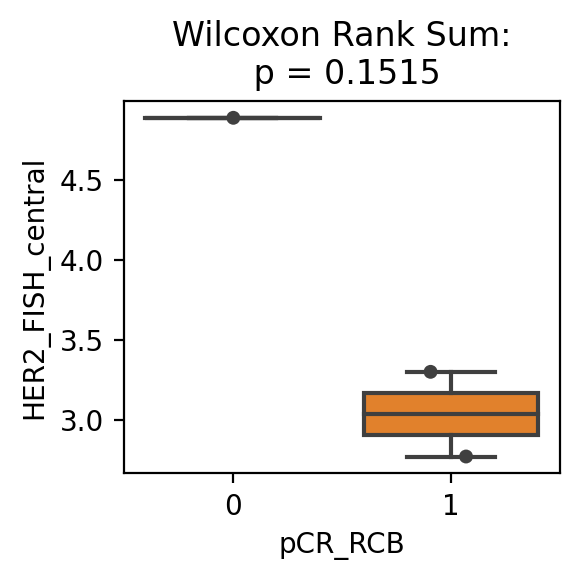

In [16]:
#categorical 'HER2_FISH_central' 'HER2_FISH_local'
s_var = 'HER2_FISH_central'
#normal?
#df_outcome.loc[:,s_var].plot(kind='hist')
fig,ax = plt.subplots(dpi=200,figsize=(3,3))
sns.boxplot(y=s_var,x=s_pcr,data=df_outcome,ax=ax)
sns.stripplot(y=s_var,x=s_pcr,data=df_outcome,ax=ax,color=".25")
df_outcome.groupby(s_pcr).groups
statistic, pvalue = stats.mannwhitneyu(df_outcome.loc[df_outcome.groupby(s_pcr).groups[0],s_var],df_outcome.loc[df_outcome.groupby(s_pcr).groups[1],s_var])
print(pvalue)
ax.set_title(f'Wilcoxon Rank Sum:\n p = {pvalue:.4f}')
plt.tight_layout()
#fig.savefig(f'./{s_date}/MannWhitneyU_{s_var}.png')

0.0002579979360165113


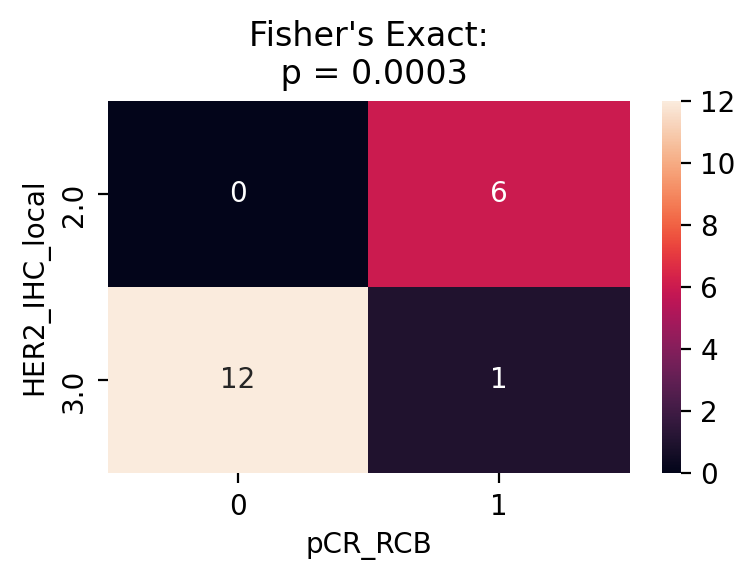

In [17]:
#chi squared significant = #'HER2_IHC_local', 'PathTstage' 'Path_histology', 'Tumor_location'
s_var = 'HER2_IHC_local' #case #1 misclassified, case 15 not measured
confusion_matrix = pd.crosstab(df_outcome.loc[:,s_var], df_outcome.loc[:,s_pcr])
fig,ax = plt.subplots(dpi=200,figsize=(4,3))
g = sns.heatmap(confusion_matrix, annot=True,ax=ax)
oddsratio, pvalue = stats.fisher_exact(confusion_matrix)
print(pvalue)
ax.set_title(f"Fisher's Exact:\n p = {pvalue:.4f}")
plt.tight_layout()
#fig.savefig(f'./{s_date}/Fisher_exact_{s_var}.png')

0.10113519091847264


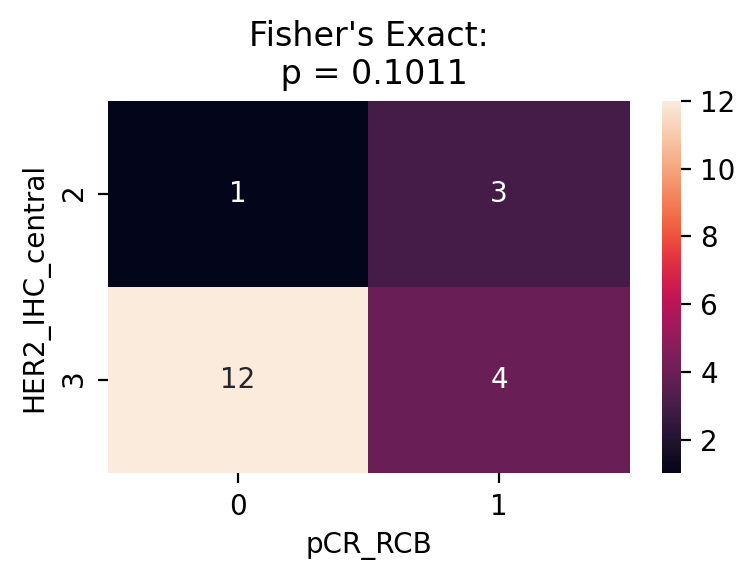

In [18]:
#fishers exact significant = #'HER2_IHC_local', 'PathTstage' 'Path_histology', 'Tumor_location'
s_var = 'HER2_IHC_central' #1, 4, 5, 10, 19 misclassified
confusion_matrix = pd.crosstab(df_outcome.loc[:,s_var], df_outcome.loc[:,s_pcr])
fig,ax = plt.subplots(dpi=200,figsize=(4,3))
g = sns.heatmap(confusion_matrix, annot=True,ax=ax)
oddsratio, pvalue = stats.fisher_exact(confusion_matrix)
print(pvalue)
ax.set_title(f"Fisher's Exact:\n p = {pvalue:.4f}")
plt.tight_layout()
#fig.savefig(f'./{s_date}/Fisher_exact_{s_var}.png')

# Cluster by cyclic IF cell type, color by pcr <a name="cluster1"></a>

For data exploration, I started by clustering the samples by different celltype groups defined by cyclic IF.

I tested the association of the HRstatus clusters and found them significantly associated with response. I haven't tested other clusters yet, but by eye they don't look like they associate.

[contents](#contents)

In [19]:
#heatmaps/barplots
#color by patient
d_fraction = {'HRStatus':'Tum',
              'celltype':'Tissue',
              'proliferation':'Tissue',
              'CellProlif':'Tissue',
              'ImmuneType':'Immune',
              'Tcell_Immune':'Tcell',
              'StromalType':'Stroma',
              'ImmuneFunc':'Tcell-Mac',
              'NonTumor':'NonTum',
              'DiffState':'Tum',
              'DiffStateHRStatus':'Tum',
              'FinalCell':'Tissue'}
mpl.rcParams.update({'font.size': 16})
df_pcr = pd.DataFrame(index=df_outcome.index)
s_grouper = 'Patient'
ls_cell = ['HRStatus','celltype','proliferation','CellProlif','ImmuneType','Tcell_Immune',
           'StromalType','ImmuneFunc','NonTumor','DiffState','DiffStateHRStatus','FinalCell']
for idx,s_cell in enumerate(ls_cell):
    print(s_cell)
    df_cell = df_data.loc[:,[s_cell,s_grouper,'countme']].dropna()
    df_prop = (df_cell.groupby([s_cell,s_grouper]).countme.count()/df_cell.groupby([s_grouper]).countme.count()).unstack().T
    #color patient sample by pcr
    for s_index in df_prop.index:
        df_prop.loc[s_index, 'ID'] = int(df_outcome.loc[s_index,s_pcr]) 
    species = df_prop.pop("ID")
    row_colors = species.map(lut_pcr)
    #clustermap plot 
    df_plot = df_prop.fillna(0)
    g = sns.clustermap(df_plot,figsize=(8,10),cmap='viridis',row_colors=row_colors,cbar_kws={'label':'Fraction Pos.'},tree_kws=dict(linewidths=1.5))
    handles = [Patch(facecolor=lut_pcr[name]) for name in lut_pcr]
    plt.legend(handles, lut_pcr, title=s_pcr,
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
    if s_cell == 'HRStatus':
        print(df_plot.index[g.dendrogram_row.reordered_ind])
    #g.savefig(f'./{s_date}/{s_pos_name}_{s_cell}_heatmap_pcr.png',dpi=150)
    plt.close()
    df_plot.columns = [f"{item.replace('___','_')}_in_{d_fraction[s_cell]}" for item in df_plot.columns]
    df_pcr = df_pcr.merge(df_plot,left_index=True,right_index=True,suffixes=('','-2'))
df_pcr = df_pcr.merge(df_outcome.loc[:,s_pcr],left_index=True,right_index=True)

HRStatus
Float64Index([20.0,  7.0, 18.0, 10.0,  3.0,  4.0,  2.0,  8.0, 16.0,  9.0, 12.0,
              15.0, 19.0,  6.0, 11.0, 13.0,  1.0,  5.0, 14.0, 17.0],
             dtype='float64', name='Patient')
celltype
proliferation
CellProlif
ImmuneType
Tcell_Immune
StromalType
ImmuneFunc
NonTumor
DiffState
DiffStateHRStatus
FinalCell


## Zcore the cell types <a name="clusterz"></a>

Z scoring makes rare cell types more influential

[contents](#contents)

In [20]:
#heatmaps/barplots
#color by patient

s_grouper = 'Patient'
for idx,s_cell in enumerate(['HRStatus','celltype','proliferation','CellProlif','ImmuneType','Tcell_Immune','StromalType','ImmuneFunc','NonTumor','DiffState','DiffStateHRStatus','FinalCell']):
    #print(s_cell)
    df_cell = df_data.loc[:,[s_cell,s_grouper,'countme']].dropna()
    df_prop = (df_cell.groupby([s_cell,s_grouper]).countme.count()/df_cell.groupby([s_grouper]).countme.count()).unstack().T
    #color patient sample by pcr
    for s_index in df_prop.index:
        df_prop.loc[s_index, 'ID'] = int(df_outcome.loc[s_index,s_pcr]) 
    species = df_prop.pop("ID")
    row_colors = species.map(lut_pcr)
    #clustermap plot 
    df_plot = df_prop.fillna(0)
    #if idx < 7:
    #    suffixes = ('','x')
    #else:
    #    suffixes = ('',f"_{''.join(ch for ch in s_cell if ch.isupper())}")
    g = sns.clustermap(df_plot,figsize=(8,8),cmap='viridis',row_colors=row_colors, z_score=1)
    handles = [Patch(facecolor=lut_pcr[name]) for name in lut_pcr]
    plt.legend(handles, lut_pcr, title=s_pcr,
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
    #g.savefig(f'./{s_date}/{s_pos_name}_{s_cell}_heatmap_z_pcr.png',dpi=150)
    plt.close()

In [21]:
df_pcr = df_pcr.drop('endothelial_in_Tissue-2',axis=1)
# save
#df_pcr.to_csv('20201030_Composition_to_pCR.csv')

## Associate HR status with pcr <a name="HRstatus"></a>

I tested the association of the HRstatus clusters and found them significantly associated with response. I haven't tested other clusters yet, but by eye they don't look like they associate.

[contents](#contents)

In [124]:
#order of samples in HR status
#Float64Index([20.0,  7.0, 18.0, 10.0,  3.0,  4.0,  2.0,  8.0, 16.0,  9.0, 12.0,
#              15.0, 19.0,  6.0, 11.0, 13.0,  1.0,  5.0, 14.0, 17.0],
#             dtype='float64', name='Patient')

In [22]:
# test significanceof HR status clusters
mpl.rcParams.update({'font.size': 16})
# 3 groups, Significant variables
g1 = [20.0,  7.0, 18.0]
g2 =  [10.0,  3.0,  4.0]
g3 = [2.0,  8.0, 16.0,  9.0, 12.0,15.0, 19.0,  6.0, 11.0]
g4 = [13.0,  1.0,  5.0, 14.0, 17.0]
df_group3 = pd.DataFrame(df_pcr.loc[:,'pCR_RCB'])
df_group3.loc[g1,'subtype'] = 'ER+'
df_group3.loc[g2,'subtype'] = 'TN'
df_group3.loc[g3,'subtype'] = 'HER2'
df_group3.loc[g4,'subtype'] = 'Mix'
df_group3['countme'] = True
#chi squared 
confusion_matrix = pd.crosstab(df_group3.pCR_RCB, df_group3.subtype,df_group3.countme,aggfunc='count')
confusion_matrix = confusion_matrix.fillna(0)
chi2, pvalue, __, __  = stats.chi2_contingency(confusion_matrix)
print(pvalue)
fig,ax = plt.subplots(dpi=200)
sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Patients'})
ax.set_title(f"Chi Squared:\n p = {pvalue:.4f}")
plt.tight_layout()
#fig.savefig(f'./{s_date}/Chi_square_HRStatus_clustering.png')
plt.close()

0.021828732412072536


## Single Variable Association with pCR <a name="singlevar"></a>

Each of the celltypes were tested for single variable association with response. If a variable had a significant (p < 0.05) assosiation with response, it was used for clustering, below.

[contents](#contents)

In [23]:
#plot single variable association
mpl.rcParams.update({'font.size': 10})
ls_sig = []
ls_pos = []
for s_var in df_pcr.columns[df_pcr.dtypes=='float64']:
    #print(s_var)
    statistic, pvalue = stats.mannwhitneyu(df_pcr.loc[df_pcr.groupby(s_pcr).groups[0],s_var],df_pcr.loc[df_pcr.groupby(s_pcr).groups[1],s_var])
    #print(pvalue)
    if pvalue < 0.2:
        fig,ax = plt.subplots(dpi=200,figsize=(3,3))
        sns.boxplot(y=s_var,x=s_pcr,data=df_pcr,ax=ax,showfliers=False)
        sns.stripplot(y=s_var,x=s_pcr,data=df_pcr,ax=ax,color=".25")
        ax.set_title(f'Wilcoxon Rank Sum:\n p = {pvalue:.4f}')
        plt.tight_layout()
        #fig.savefig(f'./{s_date}/MannWhitneyU_{s_var}.png')
        plt.close()
        ls_pos.append(s_var)
    if pvalue < 0.05:
        ls_sig.append(s_var)

# Cluster on significant variables <a name="cluster2"></a>

The variables that were associated with response were combined for clustering. However, there were still 3 mis-classified samples: 1, 19 and 20.

20 was a responder that clusterd with non-responders.

1 and 19 are non responders that cluster with responders. 

Case 1 was also predicted wrong by HER2_IHC_local (3+, non-responder), while 19 was IHC 2+ and correctly predicted as non-responder by IHC, and 20 was IHC 3+ and correctly predicted.

The hypothesis is that these tissues have unique spatial architechture associated with response/non response. I will look at tumor/stromal and tumor/immune proximity and mixing.

I also want to check the HER2 positive cells versus the images 

[contents](#contents)

Float64Index([12.0, 15.0, 16.0,  9.0,  2.0,  6.0, 11.0, 19.0, 10.0,  4.0, 20.0,
              18.0,  3.0,  7.0,  8.0,  5.0,  1.0, 14.0, 13.0, 17.0],
             dtype='float64', name='Patient')


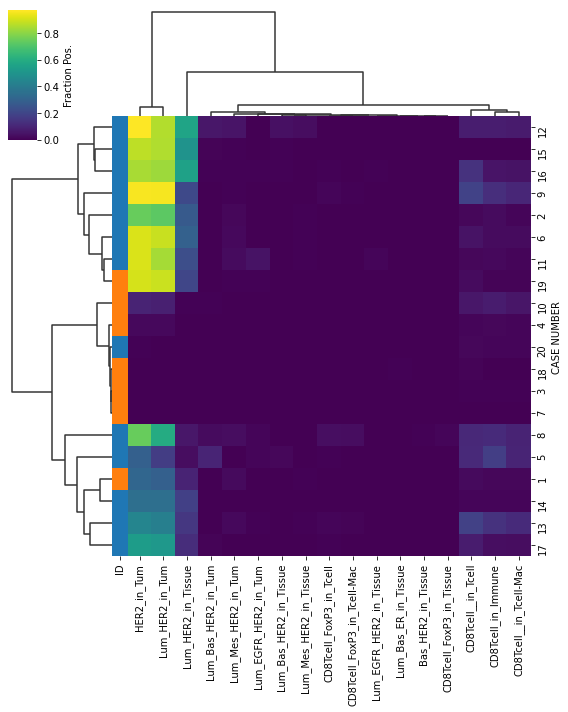

In [24]:
# better clusters (withou z score)
#g = sns.clustermap(df_pcr.loc[:,ls_sig],figsize=(10,10),cmap='viridis',row_colors=row_colors)#,z_score=1)
g = sns.clustermap(df_pcr.loc[:,ls_sig],figsize=(8,10),cmap='viridis',row_colors=row_colors,cbar_kws={'label':'Fraction Pos.'},tree_kws=dict(linewidths=1.5))
print(df_plot.index[g.dendrogram_row.reordered_ind])
#g.savefig(f'./{s_date}/Significant_Variables_clustering.png')

In [30]:
df_pcr.columns[df_pcr.columns.str.contains('CD8')]

Index(['CD8Tcell_in_Immune', 'CD8Tcell_FoxP3_in_Tcell',
       'CD8Tcell_GRNZB_in_Tcell', 'CD8Tcell_PD1_in_Tcell',
       'CD8Tcell__in_Tcell', 'CD8Tcell_prolif_in_Tcell',
       'CD8Tcell_FoxP3_in_Tcell-Mac', 'CD8Tcell_GRNZB_in_Tcell-Mac',
       'CD8Tcell_PD1_in_Tcell-Mac', 'CD8Tcell__in_Tcell-Mac',
       'CD8Tcell_prolif_in_Tcell-Mac', 'CD8Tcell_in_NonTum',
       'CD8Tcell_in_Tissue', 'CD8Tcell_FoxP3_in_Tissue',
       'CD8Tcell_GRNZB_in_Tissue', 'CD8Tcell_PD1_in_Tissue',
       'CD8Tcell_prolif_in_Tissue'],
      dtype='object')

In [36]:
# better clusters (withou z score)
#g = sns.clustermap(df_pcr.loc[:,['HER2',
# 'CD8Tcell',
#    ]],figsize=(10,10),cmap='viridis',row_colors=row_colors)#,z_score=1)
#print(df_plot.index[g.dendrogram_row.reordered_ind])
#g.savefig(f'./{s_date}/Significant_Variables_reduced_clustering.png')

In [37]:
#df_pcr.plot(x='HER2',y='CD8Tcell',kind='scatter')

In [38]:
#df_test['HER2_high'] = df_test.HER2>.7
#df_test['HER2_low'] = (df_test.HER2>.1) & (~df_test.HER2_high)
#df_test['HER2_neg'] = df_test.HER2<.1
#df_test['CD8_pos'] = df_test.CD8Tcell < .01
#df_test['respond'] = (df_test.HER2_low) & (df_test.CD8_pos) | (df_test.HER2_high)
#df_test.merge(df_pcr.loc[:,'pCR_RCB'],left_index=True,right_index=True)

Float64Index([10.0,  1.0, 14.0,  4.0, 20.0, 18.0,  3.0,  7.0, 12.0,  6.0,  2.0,
              15.0, 11.0, 19.0, 16.0, 17.0,  8.0,  5.0,  9.0, 13.0],
             dtype='float64', name='Patient')


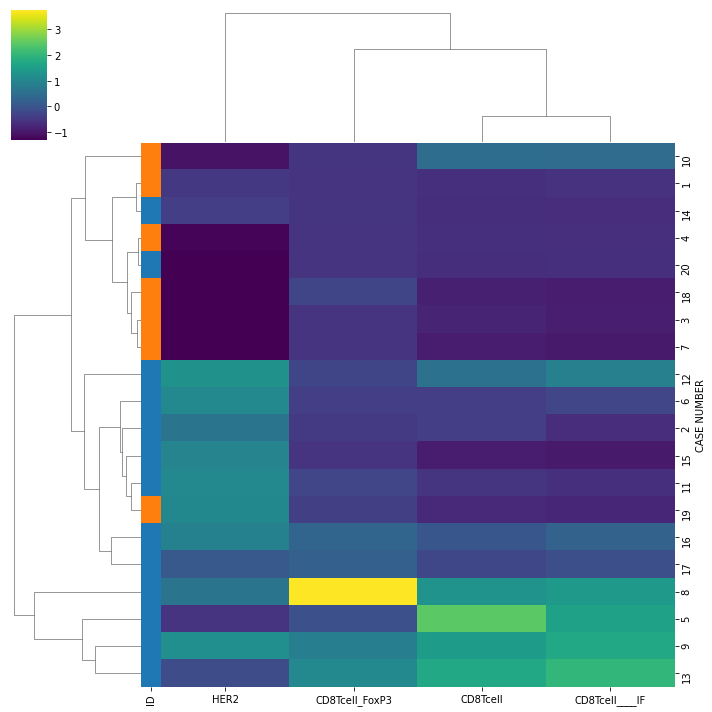

In [191]:
# better clusters (withou z score), drop all HER2 subsets
g = sns.clustermap(df_pcr.loc[:,['HER2',
 'CD8Tcell',
 'CD8Tcell_FoxP3',
 'CD8Tcell____IF',
    ]],figsize=(10,10),cmap='viridis',row_colors=row_colors,z_score=1)
print(df_plot.index[g.dendrogram_row.reordered_ind])
g.savefig(f'./{s_date}/Significant_Variables_clustering_z.png')

# Misclassfied sample investigation <a name="misclass"></a>

What variables distinguish the misclassified samples, i.e. pt 1, 19 and 20?

[contents](#contents)

In [42]:
#predicted non-responders
for s_var in df_pcr.columns[df_pcr.dtypes=='float64']:
    statistic, pvalue = stats.mannwhitneyu(df_pcr.loc[[14,11],s_var],df_pcr.loc[[1,19],s_var])
    if pvalue < 0.15:
        print(s_var)
        print(pvalue)

nonprolif
0.1226390584033864
prolif
0.1226390584033864
stromal_prolif
0.1226390584033864
tumor_prolif
0.1226390584033864
CD4Tcell
0.1226390584033864
MyeloidImmune
0.1226390584033864
CD4Tcell_prolif
0.1226390584033864
CD8Tcell___
0.1226390584033864
CD8Tcell_prolif
0.1226390584033864
stromal_PDPN
0.1226390584033864
CD4Tcell_FoxP3_prolif
0.1226390584033864
CD4Tcell____IF
0.1226390584033864
CD4Tcell_prolif_IF
0.1226390584033864
CD8Tcell_prolif_IF
0.1226390584033864
MyeloidImmune_GRNZB
0.1226390584033864
MyeloidImmune_PD1
0.1226390584033864
MyeloidImmune___
0.1226390584033864
CD4Tcell_NT
0.1226390584033864
MyeloidImmune_NT
0.1226390584033864
Lum_Bas
0.1226390584033864
Lum_Bas_TN
0.1226390584033864
Lum_EGFR_TN
0.1226390584033864
CD4Tcell_FoxP3_prolif_FC
0.1226390584033864
CD4Tcell_prolif_FC
0.1226390584033864
CD8Tcell_prolif_FC
0.1226390584033864
Lum_Bas_TN_FC
0.1226390584033864
Lum_EGFR_TN_FC
0.1226390584033864
MyeloidImmune_FC
0.1226390584033864
MyeloidImmune_GRNZB_FC
0.1226390584033864
My

Float64Index([ 1.0, 19.0,  9.0,  5.0,  8.0, 13.0, 14.0, 17.0, 12.0, 15.0,  6.0,
              11.0,  2.0, 16.0, 10.0,  3.0,  7.0, 18.0,  4.0, 20.0],
             dtype='float64', name='Patient')


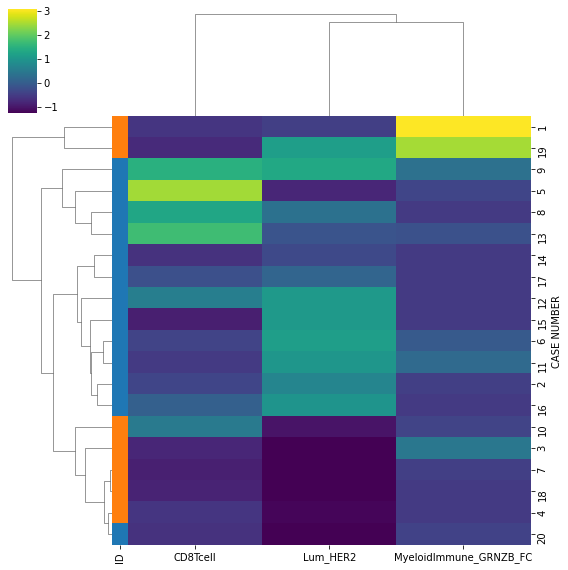

In [62]:
#pretty good 1
g = sns.clustermap(df_pcr.loc[:,['Lum_HER2','CD8Tcell','MyeloidImmune_GRNZB_FC']],figsize=(8,8),cmap='viridis',row_colors=row_colors,z_score=1) #,'MyeloidImmune_GRNZB_FC','CD4Tcell_FoxP3_IF'
g.savefig(f'./{s_date}/Outlier_analysis_composition.png')
print(df_plot.index[g.dendrogram_row.reordered_ind])

In [49]:
# better clusters with z score
#import random
#g = sns.clustermap(df_pcrz.loc[:,['CD8Tcell','CD4Tcell_FoxP3','endothelial','MyeloidImmune']],figsize=(10,10),cmap='viridis',row_colors=row_colors,z_score=1)
#ls_choice = []
#ls_choice = random.choices(ls_pos,k=4)
#g = sns.clustermap(df_pcr.loc[:,ls_choice],figsize=(8,8),cmap='viridis',row_colors=row_colors,z_score=1)
#g = sns.clustermap(df_pcrz.loc[:,['HER2','immune_prolif','ER','GRNZB_immune_NT','TN']],figsize=(10,10),cmap='viridis',row_colors=row_colors,z_score=1)

In [48]:
#pretty good 2
#g = sns.clustermap(df_pcr.loc[:,['CD8Tcell___','CD4Tcell_GRNZB_IF','CD8Tcell_FoxP3_IF','CD4Tcell_GRNZB','stromal_prolif']],figsize=(8,8),cmap='viridis',row_colors=row_colors,z_score=1) 

# Significance of Clusters <a name="clustersig"></a>

Is the a significant difference in pCR between clusters? 


[contents](#contents)

0.012107630395661886


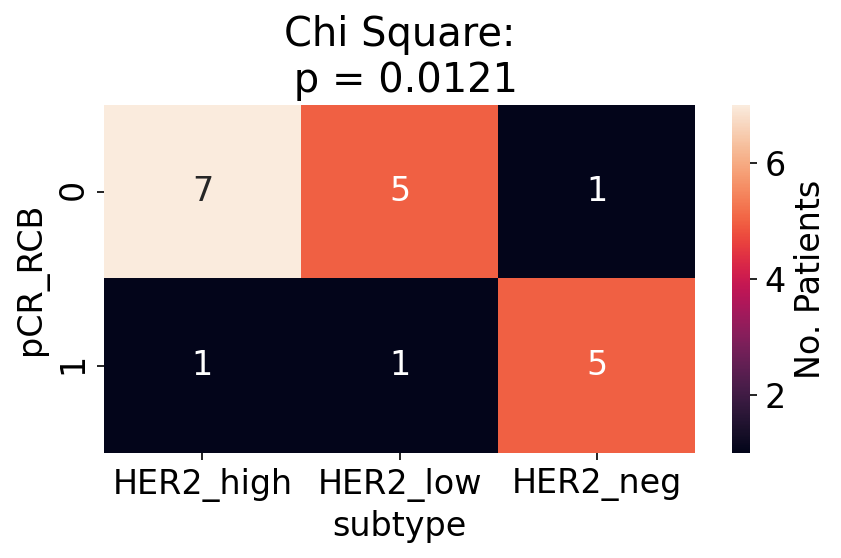

In [65]:
# 3 groups, Significant variables
mpl.rcParams.update({'font.size': 16})

g1 = [12.0, 15.0, 16.0,  2.0,  9.0,  6.0, 11.0, 19.0]
g2 =  [10.0,  4.0, 20.0,7.0, 3.0, 18.0]
g3 = [8.0,  5.0,  1.0, 14.0, 13.0, 17.0]
df_group3 = pd.DataFrame(df_pcr.loc[:,'pCR_RCB'])
df_group3.loc[g1,'subtype'] = 'HER2_high'
df_group3.loc[g2,'subtype'] = 'HER2_neg'
df_group3.loc[g3,'subtype'] = 'HER2_low'
df_group3['countme'] = True
#chi squared 
confusion_matrix = pd.crosstab(df_group3.pCR_RCB, df_group3.subtype,df_group3.countme,aggfunc='count')
chi2, pvalue, __, __  = stats.chi2_contingency(confusion_matrix)
print(pvalue)
fig,ax = plt.subplots(dpi=150)
sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Patients'})
ax.set_title(f'Chi Square:\n p = {pvalue:.4f}')
plt.tight_layout()
fig.savefig(f'./{s_date}/Chi_square_significant_clustering.png')
se_her2 = df_group3.subtype

0.008394153895755683


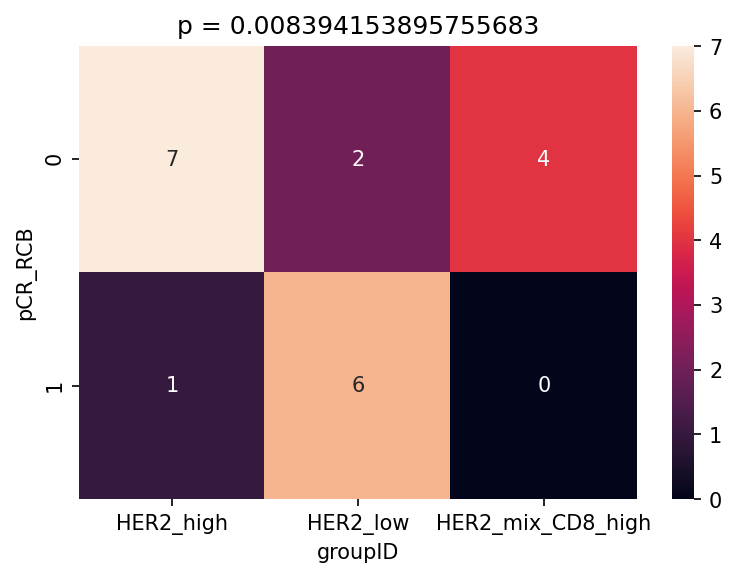

In [140]:
#3 groups significant, z-score
g1 = [10.0,  1.0, 14.0,  4.0, 20.0, 18.0,  3.0,  7.0,]
g2 = [12.0,  6.0,  2.0, 15.0, 11.0, 19.0, 16.0, 17.0,]
g3 = [8.0,  5.0,  9.0, 13.0]
df_group3 = pd.DataFrame(df_pcr.loc[:,'pCR_RCB'])
df_group3.loc[g1,'groupID'] = 'HER2_low'
df_group3.loc[g2,'groupID'] = 'HER2_high'
df_group3.loc[g3,'groupID'] = 'HER2_mix_CD8_high'

df_group3['countme'] = True
#chi squared 
confusion_matrix = pd.crosstab(df_group3.pCR_RCB, df_group3.groupID,df_group3.countme,aggfunc='count')
confusion_matrix = confusion_matrix.fillna(0)
chi2, pvalue, __, __  = stats.chi2_contingency(confusion_matrix)
print(pvalue)
fig,ax = plt.subplots(dpi=150)
sns.heatmap(confusion_matrix, annot=True,ax=ax)
ax.set_title(f'p = {pvalue}')
fig.savefig(f'./{s_date}/Chi_square_significant_clustering_z.png')

0.0009671161333609594


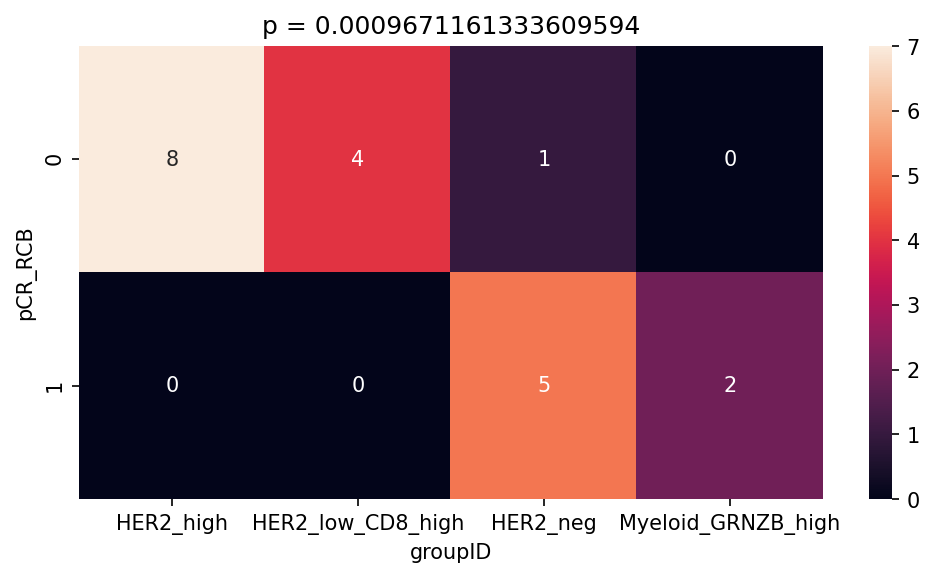

In [142]:
# 4 groups, Outlier unique variables
g1 = [1.0, 19.0]
g2 = [9.0,  5.0,  8.0, 13.0]
g3 = [14.0, 17.0, 12.0, 15.0,  6.0,11.0,  2.0, 16.0]
g4 = [10.0,  3.0,  7.0, 18.0,  4.0, 20.0]
df_group3 = pd.DataFrame(df_pcr.loc[:,'pCR_RCB'])
df_group3.loc[g1,'groupID'] = 'Myeloid_GRNZB_high'
df_group3.loc[g2,'groupID'] = 'HER2_low_CD8_high'
df_group3.loc[g3,'groupID'] = 'HER2_high'
df_group3.loc[g4,'groupID'] = 'HER2_neg'
df_group3['countme'] = True
#chi squared 
confusion_matrix = pd.crosstab(df_group3.pCR_RCB, df_group3.groupID,df_group3.countme,aggfunc='count')
confusion_matrix = confusion_matrix.fillna(0)
chi2, pvalue, __, __  = stats.chi2_contingency(confusion_matrix)
print(pvalue)
fig,ax = plt.subplots(figsize =(8,4),dpi=150)
sns.heatmap(confusion_matrix, annot=True,ax=ax,vmin=0,vmax=7)
ax.set_title(f'p = {pvalue}')
fig.savefig(f'./{s_date}/Chi_square_outlier_clustering.png')

## Correlation with HER2 <a name="HER2"></a>

Do any of the immune, stromal or tumor markers correlate with HER2+ high, low and negative?

[contents](#contents)

In [66]:
df_pcr['Cyc_HER2'] = se_her2

In [ ]:
#plot single variable association

s_pcr = 'Cyc_HER2'
ls_sig = []
for s_var in df_pcr.columns[df_pcr.dtypes=='float64']:
    #print(s_var)
    statistic, pvalue = stats.kruskal(df_pcr.loc[df_pcr.groupby('Cyc_HER2').groups['HER2_high'],s_var],
                                           df_pcr.loc[df_pcr.groupby('Cyc_HER2').groups['HER2_low'],s_var],
                                           df_pcr.loc[df_pcr.groupby('Cyc_HER2').groups['HER2_neg'],s_var],)
    #print(pvalue)
    if pvalue < 0.2:
        fig,ax = plt.subplots()
        sns.boxplot(y=s_var,x=s_pcr,data=df_pcr,ax=ax)
        sns.stripplot(y=s_var,x=s_pcr,data=df_pcr,ax=ax,color=".25")
        ax.set_title(f'p= {pvalue}')
        fig.savefig(f'./{s_date}/Kruskal_{s_var}_HER2group.png')
    if pvalue < 0.05:
        ls_sig.append(s_var)
